# Implementation of a SQP for nonlinear optimal control
The goal of this exercise is to implement a SQP solver to solve a nonlinear optimal control problem.

Consider the pendulum below 

<img src='pendulum.png' width="150">

Assuming $m=l=1$, The dynamics of this pendulum is
$$\ddot{\theta} = u - g \sin\theta$$
which can be discretized with the following dynamics
$$\begin{align}\theta_{n+1} &= \theta_n + \Delta t \omega_n\\ 
\omega_{n+1} &= \omega_n + \Delta t (u_n - g \sin\theta_n)\end{align}$$
where $\theta_n$ is the angle of the pendulum with respect to the vertical at time step $n$ and $\omega_n$ its angular velocity. We will use $\Delta t = 0.01$.
The pendulum starts at configuration $\theta_0 = \omega_0 = 0$, i.e. all the way down with zero velocity and we would like to find
an optimal control that will bring it up to $\theta=\pi$ with zero velocities.

To get the pendulum to do this movement, we write the following optimal control problem
$$\begin{align}
& \min_{\theta_n, \omega_n, u_n} \sum_{n=0}^{300} 10(\theta_n - \pi)^2 + 0.1\omega_n^2 + 0.1u_n^2\\
\textrm{subject to}\ \ & \theta_{n+1} = \theta_n + \Delta t \ \omega_n \\
& \omega_{n+1} = \omega_n + \Delta t\ (u_n - g \sin\theta_n)\\
& \theta_0 = \omega_0 = 0
\end{align}$$

In [23]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython


from qpsolvers import solve_qp, Problem, solve_problem

import pendulum
from scipy.linalg import block_diag

# Define dimensions and iterations
udim = 1
xdim = 2

dt=0.01
grav=9.81
tol = 1e-7
Xbar = np.zeros(300 * (xdim + udim)) 

## <u>Rewriting the cost function we get:</u>

$$\begin{align}
& \min_{\theta_n, \omega_n, u_n} \sum_{n=0}^{300} 10(\theta_n)^2 + 0.1\omega_n^2 + 0.1u_n^2 - 20\pi\theta_n\\
\textrm{subject to}\ \ & \theta_{n+1} = \theta_n + \Delta t \ \omega_n \\
& \omega_{n+1} = \omega_n + \Delta t\ (u_n - g \sin\theta_n)\\
& \theta_0 = \omega_0 = 0
\end{align}$$

We dont need the $10\pi^2$ term. Upon converting to a matrix form we get;
$$\begin{align}
\min_{\theta_n, \omega_n, u_n} \sum_{n=0}^{300} x_n^T G x_n +g^T x_n\\
\end{align}$$
OR
$$\begin{align}
\min_{X} \frac{1}{2} X^T G X +g^T X
\end{align}$$


where 
$$\begin{align}
X &= \begin{bmatrix} \theta_0, & \omega_0, & u_0, & \theta_1, & \omega_1, & u_1, & \dots, & \theta_{300}, & \omega_{300}, & u_{300} \end{bmatrix}^T \\
X_{des} &= \begin{bmatrix} \pi, & 0, & 0, & \pi, & 0, & 0, & \dots, & \pi, & 0, & 0 \end{bmatrix}^T , x_{des} = \begin{bmatrix} \pi, & 0, & 0 \end{bmatrix}^T
\end{align}$$
And the guess vector is:
$$
\begin{align}
\bar{X} &= \begin{bmatrix} \bar{\theta}_0, & \bar{\omega}_0, & \bar{u}_0, & \bar{\theta}_1, & \bar{\omega}_1, & \bar{u}_1, & \dots, & \bar{\theta}_{300}, & \bar{\omega}_{300}, & \bar{u}_{300} \end{bmatrix}^T
\end{align}
$$


Our final matrix for after incorporating ${X_{des}}$ will be:
$$\begin{align}
\min_{X} \frac{1}{2} (X-{X_{des}})^T G (X-{X_{des}}) +g^T (X-{X_{des}})
\end{align}$$
which can be condensed as:
$$\begin{align}
\min_{X} \frac{1}{2} \bar X^T G \bar X +g^T \bar X
\end{align}$$

Let see how G and g looks like:
$$\begin{align}
G = \begin{bmatrix} 
20 & 0 & 0 & 0 & \cdots \\ 
0 & 0.2 & 0 & 0 & \cdots \\ 
0 & 0 & 0.2 & 0 & \cdots \\ 
0 & 0 & 0 & 20 & \cdots \\ 
\vdots & \vdots & \vdots & \vdots & \ddots 
\end{bmatrix},
g = 
\begin{pmatrix} 
-20 \pi\\
0\\
0\\
-20 \pi\\
0\\
0\\
-20 \pi\\
\vdots 
\end{pmatrix}
\end{align}$$








In [24]:
def G_g_funct(iterations, udim=1, xdim=2):
    G = np.zeros((3 * iterations, 3 * iterations))
    g = np.zeros(3 * iterations)
    for i in range(iterations):
        idx = 3 * i
        G[idx, idx] = 20
        G[idx + 1, idx + 1] = 0.2
        G[idx + 2, idx + 2] = 0.2
        g[idx] = -20 * np.pi
    g = g.reshape(-1, 1)
    return G.astype(np.float64), g.astype(np.float64)



def function_tomin(Xbar: np.ndarray,iterations):
    G, g = G_g_funct(iterations=iterations, udim=udim, xdim=xdim)
    Xbar = Xbar.reshape(-1, 1)
    return ((0.5 * ((Xbar.T @ G) @ Xbar) + g.T @ Xbar)[0, 0]).astype(np.float64)

## <u>Rewriting the constraints:</u>

Our constraints are given as:

$$\begin{align}
& \theta_{n+1} = \theta_n + \Delta t \ \omega_n \\
& \omega_{n+1} = \omega_n + \Delta t\ (u_n - g \sin\theta_n)\\
& \theta_0 = \omega_0 = 0
\end{align}$$

Before going any further we have to linearize the sin function. So using Taylor series expansion we get:
$$
\sin(\theta_n) \approx \sin\left(\bar{\theta}_n\right) + \cos\left(\bar{\theta}_n\right) \Delta \theta_n
$$

So we can rewrite the constraints as:
$$\begin{align}
& \Delta \theta_{n+1} = \Delta \theta_n + \Delta t \ \Delta \omega_n \\
& \Delta \omega_{n+1} = \Delta \omega_n + \Delta t\ (\Delta u_n - g (\sin\left(\bar{\theta}_n\right) + \cos\left(\bar{\theta}_n\right) \Delta \theta_n))\\
\end{align}$$


We can rewrite the contraints in the following matrix form (for n>0):
$$
\begin{bmatrix}
\Delta \theta_{n+1} \\
\Delta \omega_{n+1}
\end{bmatrix}
=
\begin{bmatrix}
1 & \Delta t \\
\cos\left(\bar{\theta}_n\right) \Delta t & 1
\end{bmatrix}
\begin{bmatrix}
\Delta \theta_n \\
\Delta \omega_n
\end{bmatrix}
+
\begin{bmatrix}
0 \\
\Delta t
\end{bmatrix}
\Delta u_n
+
\begin{bmatrix}
0 \\
- g \Delta t \sin\left(\bar{\theta}_n\right)
\end{bmatrix}

$$

Which gives us the equation:
$$\begin{align}
Cx=d
\end{align}$$

Rewriting the constraint matrix equation as:
$$\begin{align}
C(\bar x) \bar X=d(\bar x)
\end{align}$$

$$
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \cdots \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \cdots \\
1 & \Delta t & 0 & -1 & 0 & 0 & 0 & 0 & 0 & \cdots \\
-g\Delta t \cos(\bar{\theta}_0) & 1 & \Delta t & 0 & -1 & 0 & 0 & 0 & 0 & \cdots \\
0 & 0 & 0 & 1 & \Delta t & 0 & -1 & 0 & 0 & \cdots \\
0 & 0 & 0 & -g\Delta t \cos(\bar{\theta}_1) & 1 & \Delta t & 0 & -1 & 0 & \cdots \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots
\end{bmatrix}
\begin{bmatrix}
\bar{\theta}_0\\ 
\bar{\omega}_0,\\ 
\bar{u}_0\\
\bar{\theta}_1\\
\bar{\omega}_1\\
\bar{u}_1\\
\dots\\
\bar{\theta}_{300}\\
\bar{\omega}_{300}
\end{bmatrix}
=
\begin{bmatrix}
0\\
0\\
\bar\theta_0 + \Delta t \bar \omega_0 - \bar{\theta}_1 \\
\bar \omega_0 + \Delta t(\bar u_0 -g.sin\bar \theta_0) - \bar \omega_1\\
\bar{\theta}_1 + \Delta t \bar{\omega}_1 - \bar{\theta}_{2}\\
\bar{\omega}_1 + \Delta t(\bar{u}_1 - g \sin \bar{\theta}_1)-\bar{\omega}_2  \\
\vdots \\
(\bar{\theta}_{299} + \Delta t \bar{\omega}_{299} - \bar{\theta}_{300}) \\
(\bar{\omega}_{299} + \Delta t(\bar{u}_{299} - g \sin \bar{\theta}_{299}) - \bar{\omega}_{300})
\end{bmatrix}
$$



In [25]:
def C_d_funct(Xbar: np.ndarray, iterations, udim=1, xdim=2):
    # Ensure Xbar is a 1D array
    Xbar = Xbar.flatten()

    # Initialize C and d with the desired shapes
    C = np.zeros((iterations * xdim, iterations * (udim + xdim)))
    d = np.zeros((iterations * xdim, 1))

    # Set initial conditions for the state
    C[0:xdim, 0:xdim] = np.eye(xdim)

    for i in range(iterations - 1):
        # Extract current state and control variables
        theta_bar_i = float(Xbar[i * (xdim + udim)])
        omega_bar_i = float(Xbar[i * (xdim + udim) + 1])
        u_bar_i = float(Xbar[i * (xdim + udim) + 2])

        # Extract next state variables
        theta_bar_inext = float(Xbar[(i + 1) * (xdim + udim)])
        omega_bar_inext = float(Xbar[(i + 1) * (xdim + udim) + 1])

        # Define A and B matrices for the linear system
        A = np.array([
            [1, dt],
            [-grav * dt * np.cos(theta_bar_i), 1]
        ])
        B = np.array([[0], [dt]])

        # Define column indices for the current iteration
        col_x = i * (xdim + udim)
        col_u = i * (xdim + udim) + xdim
        col_xnext = (i + 1) * (xdim + udim)

        C[(i+1)*xdim:(i+2)*xdim, i*(xdim+udim)+xdim:i*(xdim+udim)+xdim+1] = B
        
        ## xn
        C[(i+1)*xdim:(i+2)*xdim, i*(xdim+udim):(i)*(xdim+udim)+xdim] = A
        

        # Assign -I to C for the next state, ensuring no out-of-bounds
        if (col_xnext + xdim) <= C.shape[1]:
            ##x n+1
            C[(i+1)*xdim:(i+2)*xdim, (i+1)*(xdim+udim):(i+1)*(xdim+udim)+xdim] = -np.eye(xdim)
        else:
            # For the last iteration, there is no x_{n+1} in C
            pass

        # Assign values to d
        d[2*i+2,0] = theta_bar_i + dt * omega_bar_i - theta_bar_inext
        d[2*i+3,0] = omega_bar_i + dt * (u_bar_i - grav * np.sin(theta_bar_i)) - omega_bar_inext

    return C.astype(np.float64), d.astype(np.float64)

## Question 1: write a SQP solver to solve this problem

* Write down the algorithm (in words not in code), i.e. write all the steps you need to take

### Algorithm for Solving the Optimal Control Problem

1. **Reformulate the Cost Function**  
   Adjust the cost function to accurately track the pendulum’s trajectory, similar to the method shown in *Lecture 2 - LQ problems with KKT and QP.ipynb*.

2. **Linearize Equality Constraints**  
   Use a Taylor expansion to linearize the equality constraints around $\(\Delta \overline{x}\)4, yielding $G(\overline{x}) \Delta x = g(\overline{x})$, where $G(\overline{x})$ is the Jacobian matrix of the equality constraints.

3. **Formulate the Lagrangian**  
   Construct the Lagrangian $L(x, \lambda) = f(x) + \lambda^T g(x)$, incorporating both the cost and constraints.

4. **Compute Gradient of Cost Function**  
   Calculate the gradient of the cost function to use in the optimization steps.

5. **Compute Hessian of the Lagrangian**  
   Find the Hessian matrix of the Lagrangian, disregarding second-order differentials of the constraints for simplification.

6. **Formulate the Quadratic Program (QP)**  
   Combine all matrices from previous steps into a QP of the form:  
   $$
   \min \frac{1}{2} p^T \nabla_{xx} L(x_k) p + p^T \nabla f(x_k)
   $$  
   subject to:  
   $$
   \nabla g(x_k)^T p + g(x_k) = 0
   $$  
   This system can also be represented by solving:
   $$
   \begin{bmatrix} \nabla_{xx} L(x_k) & \nabla g(x_k)^T \\ \nabla g(x_k) & 0 \end{bmatrix} \begin{bmatrix} p_k \\ \lambda_{k+1} \end{bmatrix} = \begin{bmatrix} -\nabla f(x_k) \\ -g(x_k) \end{bmatrix}
   $$

7. **Calculate Total Constraint Violation**  
   Evaluate the total violation of constraints to guide convergence checking.

8. **Initialize with a Starting Guess**  
   Begin with an initial guess $\overline{x} = [0]$.

9. **Line Search Using Merit Function**  
   Use a line search with the Merit Function, which combines the cost and total constraint violation, to determine an appropriate step size $\alpha$. Solve for $p_k$ using the KKT system from Step 6.

10. **Update Estimate**  
    Update the estimate as $\overline{x} = \overline{x} + \alpha p_k$.

11. **Convergence Check**  
    If the total constraint violation is below a set tolerance (e.g., $10^{-4}$), conclude that the Sequential Quadratic Programming (SQP) has converged.

12. **Iterate Until Convergence**  
    Repeat Steps 9–11 until convergence, or until the maximum iterations are reached. If convergence is not achieved, consider tuning parameters or revising the problem formulation.

13. **Visualize Results**  
    Animate and plot the final solution along with relevant parameters for analysis and validation.


* Write (in Latex) the gradient of the running cost at a given guess $\bar{x} = [\bar{\theta}_0, \bar{\omega}_0, \bar{u}_0, \bar{\theta}_1, \bar{\omega}_1, \bar{u}_1, \dots, \bar{\theta}_{300}, \bar{\omega}_{300}, \bar{u}_{300}]^T$, i.e. for given values $\bar{\theta}_n, \bar{\omega}_n, \bar{u}_n$ and implement a function that computes it

Lets find the KKT Equations of: $$f(X) = \min_{X} \frac{1}{2} \bar X^T G \bar X +g^T \bar X$$ Subject to: $$\begin{align}
C(\bar x) \bar X=d(\bar x)
\end{align}$$.

Lets find the gradient of the cost at $\bar X$ as: $$ \nabla f(\bar{X}) = 2 \cdot \frac{1}{2} G \bar{X} + g \Rightarrow \nabla f(\bar{X}) = G \bar{X} + g $$

In [26]:
def gradient_cost(Xbar, iterations, udim=1, xdim=2):
    Xbar = Xbar.reshape(-1, 1)
    G, g = G_g_funct(iterations, udim, xdim)
    costgrad = (G @ Xbar + g)
    return costgrad.astype(np.float64)


* Write (in Latex) the Hessian of the running cost at a given guess $\bar{x}$, i.e. for given values $\bar{\theta}_n, \bar{\omega}_n, \bar{u}_n$ and implement a function that computes it
* Assume that the Hessian of the constraints is 0 (i.e. ignore the second order derivatives of the constraints)

In [27]:
def hessianmat(iterations):
    block = np.array([[20, 0, 0],
                      [0, 0.2, 0],
                      [0, 0, 0.2]])
    
    # Create the block diagonal matrix with N copies of the block
    return block_diag(*([block] * iterations)).astype(np.float64)

* Write (in Latex) a linear approximation of the constraints at a given guess $\bar{x}$ in a form $G(\bar{x}) \Delta x = g(\bar{x})$ (don't forget the constant terms in g) where $\Delta x$ represents a small variation around $\bar{x}$ and implement a function that computes both $G$ and $g$.

* Use these functions to construct the inner linear KKT system that you will solve using Numpy's solve function (this should resemble the KKT system you built in the first homework)

In [28]:
def KKT_solv(Xbar: np.ndarray):
    C,d=C_d_funct(Xbar,iterations=300)
    H=hessianmat(iterations=300)               #900X900
    fgrad=gradient_cost(Xbar,iterations=300)   #900X1     
    RHS=np.vstack((-fgrad,-d))
    LHS=np.block([[H, C.T],[C, np.zeros((C.shape[0],C.shape[0]))]]) 
    result=np.linalg.solve(LHS,RHS)
    # Extract pk and lambda from the result
    pk = result[:3*iterations, 0]        # pk is the first n elements
    lambd = result[3*iterations:,0]  # lambda is the next m elements
    return pk,lambd

* Implement a function that computes the amount of constraint violation, i.e. the sum of the absolute values of all the constraints (i.e. assuming constraints of the form $c(grad) = 0$ we want to compute $|c(grad)|$).

In [29]:
def constraint_violation(Xbar: np.ndarray):
    _, d = C_d_funct(Xbar,iterations=300)
    return (np.sum(abs(d)))

* Implement a filter linear search to test if a step should be accepted. You will implement the (simplified) filter line search egradplained below.
_________________________________________________________________________________________________________________________________________________________________________________________________________

### (Simple) filter linear search
Once you have a potential step $p_x$ and associated candidate Lagrange multipliers $p_\lambda$ (from the ``solve`` of the KKT system), you need to find a step $\alpha$ to update your guess of the solution $x_{guess}$ and the Lagrange multipliers $\lambda_{guess}$. We will accept a step that either reduces the amount of constraint violation or reduces the cost.

Let's denote $f(x)$ the cost at $x$ and $|c(x)|$ the amount of constraint violation at $x$. Initialize the variable $f_{best} = \infty$ and $c_{best}=\infty$ at the beginning of the SQP. 

Then do the following during the line search.
1. Set $\rho$ to a number between 0 and 1 (e.g. 0.5) and set $\alpha = 1$
2. If $f(x_{guess} + \alpha p_x) < f_{best}$ then set $f_{best} \leftarrow f(x_{guess} + \alpha p_x)$ and accept the step

   Or 

   If $|c(x_{guess} + \alpha p_x)| < c_{best}$ then set $c_{best} \leftarrow |c(x_{guess} + \alpha p_x)|$ and accept the step
3. If the step was not accepted set $\alpha \leftarrow \rho \alpha$ and go back to Step 2.
4. If the step was accepted update the guess $x_{guess} \leftarrow x_{guess} + \alpha p_x$ and the Lagrange multipliers $\lambda_{guess} \leftarrow (1-\alpha)\lambda_{guess} + \alpha p_{lambda}$

* Terminate the algorithm when you either reached the maximum number of iterations (e.g. 100) or when the KKT optimality conditions $\nabla_x L$ and $\nabla_\lambda L$ are close to 0, e.g. $10^{-4}$.

In [30]:
x_guess=np.zeros((900,1))
f_best=np.inf
c_best=np.inf
alpha=1
rho=0.05

f_history=[]
c_history=[]
alpha_history=[]
iterations=300

for i in range (0,iterations):
  pk, _ = KKT_solv(x_guess)
  pk = pk.reshape(900, 1)
  
  while (function_tomin(x_guess + alpha * pk, iterations=300) > f_best and
       constraint_violation(x_guess + alpha * pk, iterations=300) > c_best):
        alpha = rho * alpha
  f_best=f_best = function_tomin(x_guess + alpha * pk, iterations=300)
  c_best=constraint_violation(x_guess+(alpha*pk))
  alpha_history.append(alpha)
  c_history.append(c_best)
  f_history.append(f_best)
  print(
      f"Current Cost = {f_best}  Current Constraint Violation = {c_best}")
  x_guess = x_guess + (alpha * pk)
  if (c_best < tol):
      break
print(f"Total iterations needed = {i+1}")
theta = x_guess[0::3].T
omega = x_guess[1::3].T
controls = x_guess[2::3].T
print("DEBUG POINT")

Current Cost = -14927.779426619063  Current Constraint Violation = 21.57408353771614
Current Cost = -23828.810833427102  Current Constraint Violation = 17.8875208405832
Current Cost = -24926.232488744583  Current Constraint Violation = 0.06013749482405207
Current Cost = -24926.596929091244  Current Constraint Violation = 4.6576718491503705e-06
Current Cost = -24926.597229595216  Current Constraint Violation = 1.02573385250067e-08
Total iterations needed = 5
DEBUG POINT


In [31]:
x_init = np.array([theta[:, 0], omega[:, 0]])
print(x_init)
pendulum.animate_robot(x_init, controls)

[[-7.10542736e-16]
 [ 0.00000000e+00]]


<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAMkNtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE5
IGxvb2thaGVhZF90aHJlYWRzPTMgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DT1liIQAP//+92ifAptaQ3qA5JXFJdtPgf+rZ3B8j+kDAAADAAADAAAVt6RlhkJ0L/JiAAAFfACy
BmSZ6XFJE4AKCdnVuDJz6YRA9aXK+D92cTMu+hvWEgrm6VgN+NN58xr5ENbD+oIFbJh3Hp5aaZ7q
A6T9bic4xbRxQpgkTkdJXn7mxrIyGimVgSkYPxFhDkBW2ULOVc3poxMubwa8KN+BHPPpeuCVceyT
K8Sutw9A6fdPtZ/8tSIN4rY0xxRToEK/HoC502qtOxtzT5Rshcw28vw//QkgQVxA2eXnAUAxIAOb
GLPoKfXjk5pFs/rBKwvOmK74JvarEOzfC34c3bf3d3EXiENvbfmgN445qoqXG0rX23WzVwbHgmtm
Q3VcS412auklSczhDcDlDnRxPyboQULE4aoDSPdIVIwcHKRFurb7GI3GohEQb37fenqBMoKtvGDc
ZQX/K0/AIDssxoDtSaQ9lJ/bFa/O6nXXKcpTKr+GKYKpYMHoFtBt5JcYBX6JL7HvFE23bTVFiJ2i
L2/SIrRv7xzo1biqog9FulZ9vPln70zwy1hTxAooHAEnuGRm+741AFjGQ4ELGQ/NJWF2pLTK+Ad1
vD8Pbev5HVEAb4r90LB+BOzJj0e61/EbH1E8xefu3/RleFlNwAww0NXSCQNCmpgBD9/cGehT78cf
fdZeSYfh4j42j3K8r7hTcJ8XPTimB/5TR2ewjoZ69kvbn0UVGO8BXBm5gBaaLUYjKX3AFjv/WSAB
1l9wgVwA4xaXuWAAAAMAAA0+Mx3VFhjCJ35zx2KPVXy/X//MBYzpt/ACmFNpYWvW4jC2HqbrV04K
tyiKfsqxHioMxH4PoOwM6Qc0VhicD8vNu8KxWQfc4eMl6XZQHH0Je/NllYEvtdtiOEp6TMoeHka/
dceDqNaR0raHZ7ptRX5klMO2E+/CdWCjEVZYZOL13BjJPtiXXYVAMRjEQDJbQywgRhPDZBP7SLEl
ygxcyZj6w2GBrxT1XThJPF3R50QInTtoXQA87gfHskEbov+Ar48TFGGmNYmMWsntuuZr/DowAGtR
3h6xwmo90/pEIR7DRszTyPSabgp5qZaFzi0xyqaBfXian/xuhhmOFA1YjDB8Fce0aUBwz5khlvYd
ggnMwuwC8SpP+imOj4+E6W2gda/p1Cy2nd0QMWdCtKaxi7auvDxPjoYWkc4pKAjW4bONBytSMqAA
AAMAAAMABdWM7EIQbX46gwWRhplLPIs7QIzJ3v7LbkMO7zmoZu3zqrsmGY0+TJXjy5CiQdFq4J4C
s1+X3j5nm+QAqoO7xT85N0yBXH7EJ+awnyC+OG6IAVmlzYAJUA3Zl2StFtGHCk1XJ+ly3WiYkC9Y
V5XjoWdP8qbdS2jGk2D+HmiXs+e5Au4x8aF2So32xIk/j9uIm2ZNEuXWd16RGX7bAfjEEWTXqGYB
bT4qp0EqkBs/WElZ55/Q/no7MUZrMcZTD+F82q2mBRgH0g5gidWOq8Iq0ceDE78pzB9dLaX5NCox
9cgH3ik+onHGMaYs8fLsY4Pc6DBfi4XNvnedUhU1T15Kjzw5LFUxh1S2L8PrtZDBPvH2vj9RK+UQ
LBmwF5ezChCEptTTXlvz7t7WQym7qwwNByZtAKJ6XJ8A2MQkeKzj+Bpu1YjrlrBVhHUM6u9ZLe8D
ZVFvsvP2N9t+Rg8ydyuSpkTLCS7TyB7xchC+/OJQxLXDOuSdLZ7I7WOOP1bb01BFPdMU337GTZng
Iu0vN4siAjYqx8FD5hvZ/jQdD4Qk9nAvT1KzgJVbXpo+KJ7H/+oq/auq3yedmsJVKBJoWQbZAaDz
OTVRABORM+PDSoJLT3ZsvJ+Tcmqa7Y4qU1EbQzobh3gHt8O8mpUBex/trmK/Xf0f/aokUadg4YjI
4OCGRUyptYD9TiBjk1cFierYmtn19v/zdXl/N2kAdOLOTDT1oMsYf72Gb/TXWHReGge+yDwJA8uJ
+uBmbi7r+djcdPtY/fK4qaN3HggsegNA62H/HLS7m3OpiyWz0SdbrcC50vFn/4VO/L65UAkjnyej
c7Np2FyQBrBGVb7S9xvwvk4bQjFimA/oktGIu9g/2uTu5eKy6ml/+YV6T0//36xnhAnz5hg+SqCO
O70ahT1UTp1ug8w8lsqBlndFs9DDu0QlRdeTYhdrRccucttpz/3ZzEj54ipYKIminO8GxUl5Ej7Q
97luupZhDA9OPGCN3oOa7VKn/MeQD5l6emT0i93zQqWhdyQfKDZpPJ2WvO97CWUO1VA5ec4s6pVa
NmzWQuCz7z/ydlB9cj32Xynuf+7ciC07MQ7g+7uGJO3UrF3TZHNHyO8+RDFuzmk+0mNWcdsG18Pq
+aWVRzeD4PIJA0H9LXxMSGt3vsUxfX8X/B33f05UMcogP5iRdUeoL1jlQ3/nenTL1dK5ZspUljvB
ymU+Gm2D+ynIznh2ZQXpLsXUOAACNzl7ZyXb64YwLTihuhCJ2y6E1taWBqTbNiLT3X/hm9vZYBgX
PtIVyXwuPOLvzURtVuYTXSmlhn8NMScrTfRZMjZDgzadL04Ee15BZWx3e+jI7NXeZH+0uU8O63to
29A5guKwVdWOZUi3L17VYetGYyfLrE2CATPM+qt3Qm5RPtkut8pUpEzTAe+v/K7kQz0cZzL90xBF
n9Kwu9Nn/0LkOtNAnnlkoIUhOQtMpbc/u86CDlmLPCXPXWbuz7BNk6X7WoIxuj/Tmo/hkq37Sy5Z
0lV7EWdH/0nXyf30LqUh9j9QR1sMuG9QITjt+gWhO5Vm6gfT1e+3SOMFwTWPrtcflCufvHChUTRn
A0QIGFzuAzBYPPIjmDum8KjiuUGVeL6EWaR0bhffG/gTib7qmhye6ePHflntYANtK7TYt7EKYuhE
/9zw6V7Am/whv5fz5M0HF

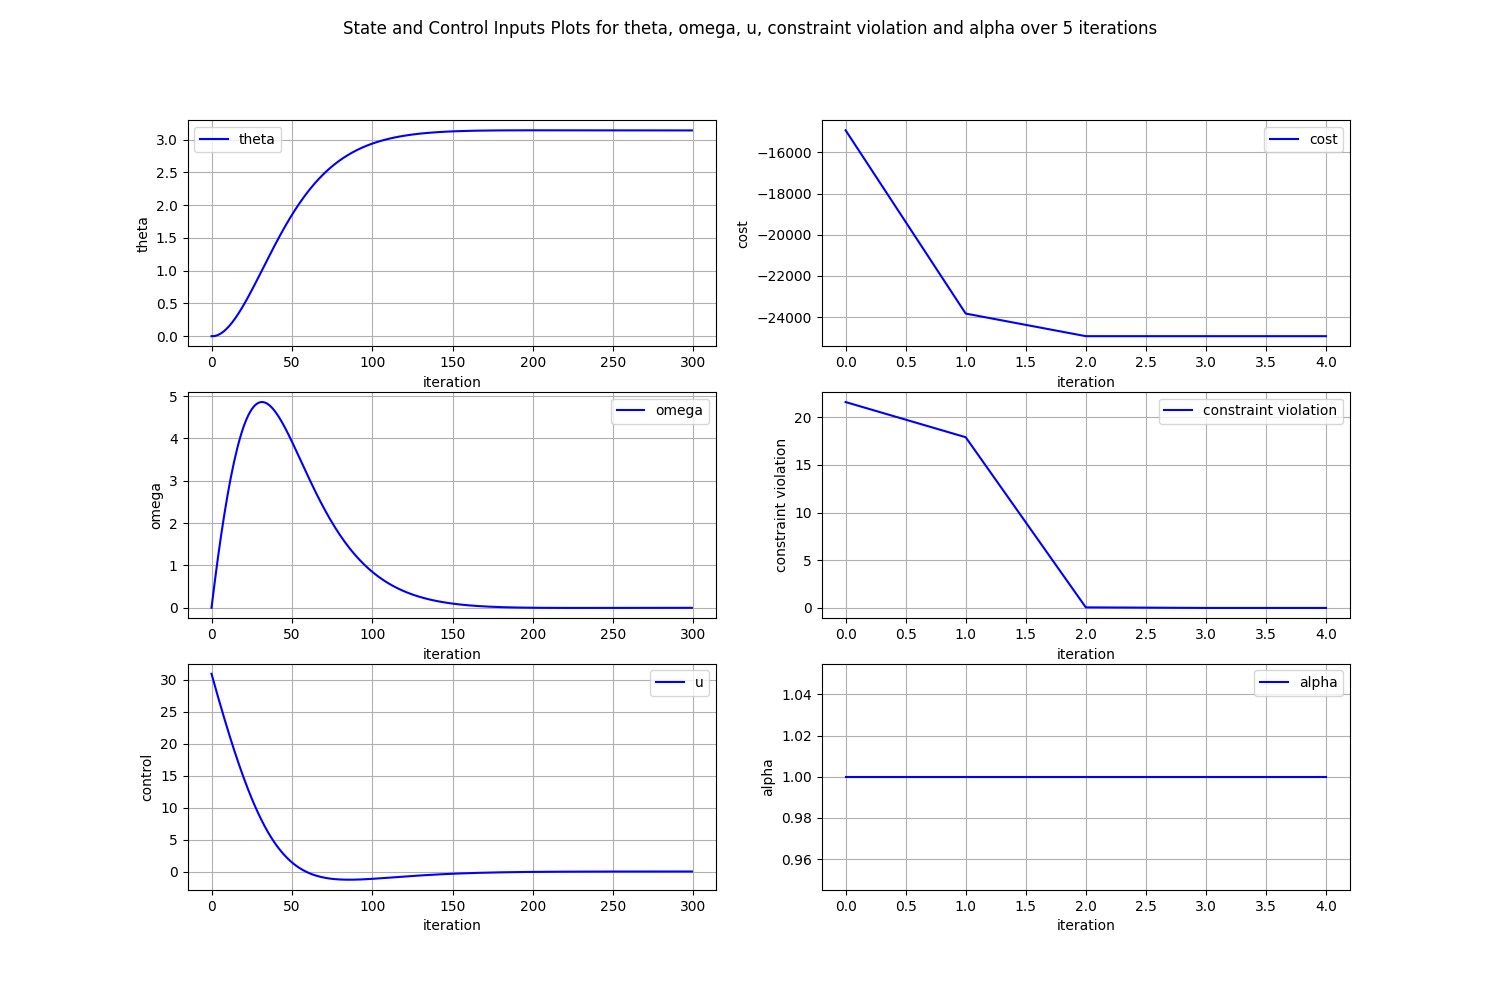

In [32]:
x_figsize = 15
y_figsize = 10
# Create a time array based on the number of columns in x1 or x2
time = np.arange(theta.shape[1])

# Create a single figure with a 3-row, 2-column layout
fig, axs = plt.subplots(3, 2, figsize=(x_figsize, y_figsize))
fig.suptitle(
    f"State and Control Inputs Plots for theta, omega, u, constraint violation and alpha over {i+1} iterations")

# Plot theta
axs[0, 0].plot(time, theta[0, :], label='theta', color='blue')
axs[0, 0].set_xlabel('iteration')
axs[0, 0].set_ylabel('theta')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot omega
axs[1, 0].plot(time, omega[0, :], label='omega', color='blue')
axs[1, 0].set_xlabel('iteration')
axs[1, 0].set_ylabel('omega')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot u
axs[2, 0].plot(time, controls[0, :], label='u', color='blue')
axs[2, 0].set_xlabel('iteration')
axs[2, 0].set_ylabel('control')
axs[2, 0].legend()
axs[2, 0].grid(True)

# Plot cost
axs[0, 1].plot(f_history, label='cost', color='blue')
axs[0, 1].set_xlabel('iteration')
axs[0, 1].set_ylabel('cost')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot constraint violation
axs[1, 1].plot(c_history, label='constraint violation', color='blue')
axs[1, 1].set_xlabel('iteration')
axs[1, 1].set_ylabel('constraint violation')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Plot alpha
axs[2, 1].plot(alpha_history, label='alpha', color='blue')
axs[2, 1].set_xlabel('iteration')
axs[2, 1].set_ylabel('alpha')
axs[2, 1].legend()
axs[2, 1].grid(True)

## Question 2: write a SQP solver with inequality constraints
Modify your SQP solver in order to enforce the additional constraint $-4 \leq u_n \leq 4$. 

In this case you will need to use a QP solver instead of the ``solve`` function. Please use the [qpsolvers](https://pypi.org/project/qpsolvers/) library (use ``pip install qpsolvers`` to get the latest version 4.4.0 and use ``cvxopt`` as QP solver). You may access the Lagrange multipliers of the solution following [this example](https://qpsolvers.github.io/qpsolvers/quadratic-programming.html#dual-multipliers).

Update the convergence checks accordingly (using the KKT condition for the nonlinear problem $\nabla_x L$). Also update the computation of the constraint violation by computing the amount of inequality constraint violation in absolute value (note that it should be zero when the constraint is satisfied).

Once you have a solution, make sure to check that it satisfies the constraints! You can also use the function ``pendulum.animate_robot`` to display the pendulum motion. Please answer the following questions:
1. How many iterations did it take?
2. Plot the solution (angle, velocity and control)
3. Plot the amont of constraint violation per iteration of the solver
4. Plot the cost per iteration of the solver
5. Plot $\alpha$ for each iteration of the solver
6. Compare this solution with the solution from Question 1. Are there any qualitative differences in the pendulum behavior? Did the solver converge faster or slower?

In the given problem Accomodating the change $w.r.t.$ $\Delta  we have to handle an additional inequality ; $$-4 \leq u_n \leq 4$$ 
which can be expressed in the matrix form as:
$$\begin{bmatrix}0 & 0 & 1 \\ 0 & 0 & -1\end{bmatrix} \begin{bmatrix}\bar{\theta}_n \\ \bar{\omega}_n \\ \bar{u}_n\end{bmatrix} \leq \begin{bmatrix}4 \\ 4\end{bmatrix}$$

Accomodating the change $w.r.t.$ $\Delta x$ we get $H(\bar{x}) \Delta x \leq h(\bar{x})$ as,
$$\begin{bmatrix}0 & 0 & 1 \\ 0 & 0 & -1\end{bmatrix} \begin{bmatrix}\Delta \bar{\theta}_n \\ \Delta  \bar{\omega}_n \\ \Delta  \bar{u}_n\end{bmatrix} \leq \begin{bmatrix}4 - \bar{u}_n \\ 4 + \bar{u}_n\end{bmatrix}$$

Using this logic, the below function has been defined.

In [33]:
def form_ineq_const(Xbar: np.ndarray, N=None):
    u_k = Xbar[2::3].flatten()
    if N is None:
        N = len(u_k)
    H_i = np.array([
        [0, 0, 1],   # Coefficients for u_n <= 4
        [0, 0, -1]   # Coefficients for -u_n <= 4
    ], dtype=np.float64)
    H = block_diag(*([H_i] * N))
    h = np.empty((2 * N,))
    for n in range(N):
        h[2 * n] = 4 - u_k[n]
        h[2 * n + 1] = 4 + u_k[n]
    return H.astype(np.float64), h.astype(np.float64)

In [34]:
def solve_KKT_eq_ineq_constr(Xbar: np.ndarray,iterations):
    C_Mat, d_Mat = C_d_funct(Xbar,iterations)
    H_mat = hessianmat(iterations)
    fgrad_Mat = gradient_cost(Xbar,iterations)
    H, h = form_ineq_const(Xbar)
    problem = Problem(P=H_mat,q=fgrad_Mat,A=C_Mat,b=-d_Mat.flatten(),G=H,h=h.flatten())
    solution = solve_problem(problem=problem,solver="cvxopt",verbose=False,initvals=None)
    return solution


In [35]:
def tot_constraint_violation_eq_ineq(bar_x: np.ndarray,iterations):
    constraint_violation_eq = np.sum(abs(C_d_funct(bar_x, iterations=iterations)[1]))
    u = bar_x[2::3].flatten()
    constraint_violation_ineq = 0
    for u_i in u:
        if u_i > 4:
            constraint_violation_ineq += np.abs(u_i - 4)
        elif u_i < -4:
            constraint_violation_ineq += np.abs(u_i + 4)
    return (constraint_violation_eq + constraint_violation_ineq).astype(np.float64)

In [36]:
# Initialize variables
x_guess = np.zeros((500 * 3, 1)).astype(np.float64)
f_best = np.inf   
c_best = np.inf
alpha = 1
rho = 0.05
f_history = []
c_history = []
alpha_history = []
iterations=500

# Main optimization loop
for i in range(iterations):
    res = solve_KKT_eq_ineq_constr(x_guess,iterations=500)
    pk = res.x.reshape(iterations * 3, 1)

    while (function_tomin(x_guess + alpha * pk, iterations=500) >= f_best and
       tot_constraint_violation_eq_ineq(x_guess + alpha * pk, iterations=500) > c_best):
        alpha = rho * alpha

    f_best = function_tomin(x_guess + alpha * pk, iterations=500)
    c_best = tot_constraint_violation_eq_ineq(x_guess + alpha * pk, iterations=500)

    alpha_history.append(alpha)
    c_history.append(c_best)
    f_history.append(f_best)
    print(f"Current Cost = {f_best}  Current Constraint Violation = {c_best}")

    x_guess = x_guess + (alpha * pk)
    theta = x_guess[0::3].T
    omega = x_guess[1::3].T
    controls = x_guess[2::3].T

    if c_best < tol:
        break

theta = x_guess[0::3].T
omega = x_guess[1::3].T
controls = x_guess[2::3].T
print(f"Total iterations needed = {i+1}")
print("DEBUG POINT")

Current Cost = -10816.493184907964  Current Constraint Violation = 0.9908629060371568
Current Cost = -11042.385670136158  Current Constraint Violation = 0.02470851455258748
Current Cost = -11059.561257270565  Current Constraint Violation = 0.014084372022176309
Current Cost = -11073.087698384928  Current Constraint Violation = 0.01181153336009291
Current Cost = -11085.03085885569  Current Constraint Violation = 0.010912803839331181
Current Cost = -11096.452191146274  Current Constraint Violation = 0.010952019662051754
Current Cost = -11108.232914823871  Current Constraint Violation = 0.011905426150733683
Current Cost = -11121.35469029571  Current Constraint Violation = 0.014037157900778733
Current Cost = -11137.176928031982  Current Constraint Violation = 0.017982295928388597
Current Cost = -11157.90563484091  Current Constraint Violation = 0.02512139402248105
Current Cost = -11187.53518167869  Current Constraint Violation = 0.03846162923310286
Current Cost = -11233.839405861876  Curren

In [37]:

x_init = np.array([theta[:, 0], omega[:, 0]])
print(x_init)
pendulum.animate_robot(x_init, controls)


[[-3.46654393e-18]
 [-1.51282193e-16]]


<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAXWVtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE5
IGxvb2thaGVhZF90aHJlYWRzPTMgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DQdliIQAEP/+94G/MstfIrrJcfnnfSyszzzkPHJdia640AAAAwAAAwABR4e1643dg1tJ0AAAGsAD
pCLH/2+kONwAT9lg/NYjL/FoB9aiK4jE+YrYPvM3VJY4vjNnyLGP2YlbJp/NpA8k+C6YwpDlXn2f
y1TN9QNLS2doYg16nA3KBIICjrY2PQjGG/lJWgkVRima9js6Vx5WimbQrt72ItjNL7sLxElEA17m
hCeWbA7zyXROB8c1qwBwG6mF4Z9p4RctmYdY75fZ9PIcL6+1DtNo159DsIedHWW5BeeoUeMIr15+
LI/6q7q3wu/lDZN9tIlTOzRJ5hxurCa6TP3YdJ0Pua9/TkOnB1BZtIQdZE2NNeG6ZBWKX2qe8rir
o4hVHk6AK1m3pSBFYkubBzjVbb5azjAs67d441UqfxQIdZAC3wXGhd0Df4sjAsAiUQ3i9flvYL7N
AfNDl++9aqNS+m/EntCRwqCe8BI4h+X6tXM0ZlI2ui7fnCbPrzprCur/Qlv/AcWwh2PCPV27J9Hh
B4sbRpm2Il9JEsGqAKrFjtq/wKfkNJeUUJRqCO8O4BNTkM1gkUt/4YYDveK6vKxrr1xGInxBFkRx
Ra/U1q66FY5rPKRGvy/lhCV0gLPWM/Uwd4ACy0QsnRfL+3ezliZm8228ZiCQM/Bb7Hih+NU4fPzV
mXyFXbybWT3q7qlyOdubg07ODGm3wBRMgDV2F09QRWcgoRac1e6IX088F59nygAudtZ5wAAASwwU
cqaZXL0UXzviZELNw197oAtAbVd689mZlrxJVD2nKaUzy2QETgxH+VjLUGW4nahqUgWQqDMfnRA9
lcxOpvul0EAwcmU/0ADaLvjFil9t7FUYKNxT6HPKJl9bOWLYqE+Cy39/mB8mN+2C9yTgeLkAYVNj
W62F82r/AqVC2BbuZp4VB+J9deuuOciIUAihH1mqc5GMh8KZmyduCGi7jBcE8GKK7Ktho1WaT7h0
oHuZDvhA+oN7r4xx/LU72e6n74sxOP/4YHwYrCx4uunVofIvqDyI8tU9VfBCymj6+aeibavntZjy
E6vpfbntb9PpYz8yDN5s//onJnSdeCwDlC2zfnnDF5/i64VFsUozdyzoOAFZ/mOlz4pgdYHuape7
FIxIdRoSAawZDZO38KdLp+RpovTr0L2f0BYxITknCj6MVWNAzL4MZObkl/IMFvB8GmNlRoJiqJlg
j7pjd+Pg+TIcTaOh3Hhwm1LCfZq7F2gKNLavE+1/fnaJu2EkPlDbBe79z2sK2GzWNH8dQ2kX9Oge
pUTFn7s8Xu+B5dZO3dtidtkByvTKE4cqyaIZ+rn6dU/TojPRCHEEcSW3uTbLaaRKYavFukjysCpZ
scunqr5KYxW3tLQpyuc2aArtrn1H00FYc1TZvL03yIlB6lsdzhvwJguMxE2xPkvhZ0bNHqud8P+9
yV7E9n6ZCECHjttCTTUuzCf2MDguo0pWFP5+n4WXO09zTmZyubzXPaEplpn4jT/t+viDgeZsozn5
9wJlq8rKAHxTBVD3odq1mhYfEY4xEa2NMwDnvFHDUBIzgdDU8eitxaXj6uwhVExHadYR54HV5/tJ
+YmZjURkeHMZudpH61oo1uFrAo2P/1meqqWhNYO1yD7m9JwwGU4qnbvcZ/tpzDypiPFPy7fnYbzK
IOhnl4q5JN4yDVlbQHqjBeBO7R4aZQvhMQKdbA8GDQokC8xJSFS3c4ToRTRzv/B78Br1lIzWOmxp
JXpOjhsN0TNF4XRN0KHONI2JyeXuWmlqfAbXNuSTNTujaWOvaw0EG76Eu/8KrrYs94bGcD3UtCFI
xUH7M11OFU4u8f/PluX83tm3xJGFrF39amDe7ckATbH89J8Gge+x5HeiTYn64GZuLuv5uOXg6g73
yuKmjdxCMcFOBoHWw/45aXgYGinn16ign3t5ivkwTycaQff5fXK0tILpp6Nz1p34YkfB07JLOZBA
N+F8nDZ+H3/wH9EloxF3sH+11dSayXh39s9iToKufm96QZ4QJ8+YYPkuORZD6r3i9VE6dboP/Zxz
Yky/J23uigsDsSouvJsQu1owKu0sLpt/3aiMmXOT9l2VdjHsona9ITCAXNaINUVF4X/cb7DVIa+7
1lhOMv1bHtEidAIu0gLsp4N9SlMS/ennvPL61Tp3UJbYfQjx46hUVEsmgfbcGIdMBpgN7/8HXIbj
+0MVu83Dq1heJGDsTRtWcFPtTE7yD6P6EW9DiYoYWIsez5Q0lOYevz6Ktmb8krt3AD89bDijWM2G
prImxPLabhH8JrnaaSs1xjv5TFFHvWfKGqwWbej3QUaHYPPaI/vjuRJAbix6WxxO+1wvof30Zt5F
RL+8hH0xv2AugYYB4oQJEAA7DH8cLDDbBxDu8RhBKOFr4l8HR1N2Q4ieXbeYunPkQwmAXKgXknzv
MmvIJZvAmp7HZ7caOuQkVMT9LNx/E5gIoKCAcQV1mQx+M5Txf7KSdyh3zjcR/3kg3d253TL5npBy
f6FZFzl3+/GcgwLm55VXiuMhCOkMgFeFmbgaBEHpOF2aY8Nxsj64avsvzQxE0/HK1YKHW/KR2uXe
RVuRvquqSyzNawqkXOYIA4inXVdAtfqjVbHzBdfTtiiRYoyWsuJnYCeJ3hNLsYQru080Grushgmb
7VFab2dJxa0F9bAGSpAoQE/qH8YjdaijM5VnPJG+P4tDJ5T4PEr8eRZyzDPEiFGm/V0gFjFs+xOF
DntebdeXrvPzPxRIXbUns+v/7ztLzvVbaobUFtfxpkR7qigufM4tjXEYCrNtPU5DNYJMP/4rIDlI
rskynohWkO8PUF+A3xkMLgRCyr0VdyPPZSsfKDbMwM9BfPeM/wBH25FKWz88g3+Yu5iaoE+aZBI6
u+ileC9VVhpw4SkKgHnMK

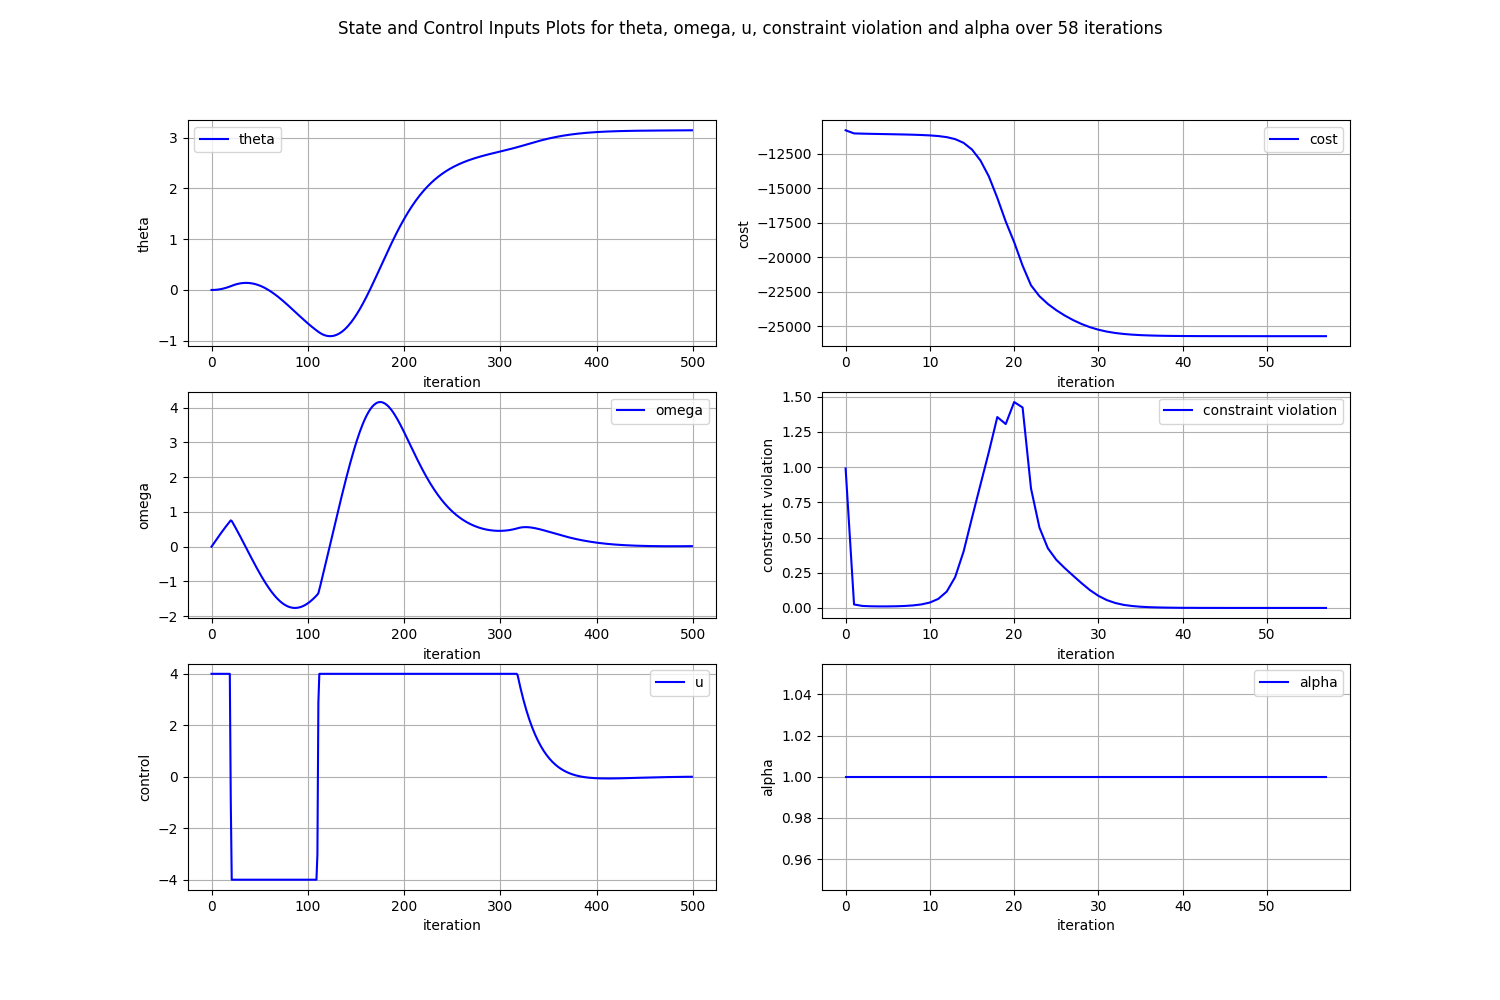

In [38]:
x_figsize = 15
y_figsize = 10
# Create a time array based on the number of columns in x1 or x2
time = np.arange(theta.shape[1])

# Create a single figure with a 3-row, 2-column layout
fig, axs = plt.subplots(3, 2, figsize=(x_figsize, y_figsize))
fig.suptitle(
    f"State and Control Inputs Plots for theta, omega, u, constraint violation and alpha over {i+1} iterations")

# Plot theta
axs[0, 0].plot(time, theta[0, :], label='theta', color='blue')
axs[0, 0].set_xlabel('iteration')
axs[0, 0].set_ylabel('theta')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot omega
axs[1, 0].plot(time, omega[0, :], label='omega', color='blue')
axs[1, 0].set_xlabel('iteration')
axs[1, 0].set_ylabel('omega')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot u
axs[2, 0].plot(time, controls[0, :], label='u', color='blue')
axs[2, 0].set_xlabel('iteration')
axs[2, 0].set_ylabel('control')
axs[2, 0].legend()
axs[2, 0].grid(True)

# Plot cost
axs[0, 1].plot(f_history, label='cost', color='blue')
axs[0, 1].set_xlabel('iteration')
axs[0, 1].set_ylabel('cost')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot constraint violation
axs[1, 1].plot(c_history, label='constraint violation', color='blue')
axs[1, 1].set_xlabel('iteration')
axs[1, 1].set_ylabel('constraint violation')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Plot alpha
axs[2, 1].plot(alpha_history, label='alpha', color='blue')
axs[2, 1].set_xlabel('iteration')
axs[2, 1].set_ylabel('alpha')
axs[2, 1].legend()
axs[2, 1].grid(True)